#### RL Course by David Silver

## Lecture 4 Model-Free Prediction

- Monte-Carlo Learning
- Temporal-Difference Learning

In [80]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from random import shuffle

定义游戏“二十一点”（Blackjack）
[规则](https://zh.wikipedia.org/wiki/%E4%BA%8C%E5%8D%81%E4%B8%80%E9%BB%9E#%E4%BA%8C%E5%8D%81%E4%B8%80%E9%BB%9E%E7%9A%84%E7%8E%A9%E6%B3%95)
![游戏规则概述](img/Blackjack.png)

In [164]:
class Player:
    '''Player of Blackjack game.
    
    Attributes:
        have_usable_ace: A boolean indicating whether player has a usable 'Ace' card
        current_points: A integer of player's maximum current points
    '''
    def __init__(self):
        self._cards = []
        self.have_usable_ace = False
        self.current_points = 0
        
    def get_card(self, card):
        '''Get a card from the card deck.'''
        self._cards.append(card)
        if card == 1:
            self.have_usable_ace = True
            
    def update_points(self):
        '''Calculate current points.'''
        self.current_points = 0
        for card in self._cards:
            if card < 11:
                self.current_points += card
            else:
                self.current_points += 10
        if self.have_usable_ace:
            if self.current_points < 11:
                self.current_points += 10
                
class Dealer(Player):
    '''Dealer of Blackjack game, another kind of player.
    
    Attributes:
        face_up_card: A integer, the number of dealer's face-up card
    '''
    def __init__(self):
        Player.__init__(self)
        self.face_up_card = 0
    
    def get_card(self, card):
        '''Get a card, and mark the first card as face-up.'''
        if len(self._cards) == 0:
            self.face_up_card = card
        Player.get_card(self, card)

class Blackjack:
    '''Blackjack game.
    
    Attributes:
        winner: A string of winner's name.
    '''
    def __init__(self, num_of_card_desks = 1):
        self.__cards = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13] * 4 * num_of_card_desks
        self.__player = Player()
        self.__dealer = Dealer()
        shuffle(self.__cards)
        self.__player.get_card(self.__cards.pop())
        self.__dealer.get_card(self.__cards.pop())
        self.__player.get_card(self.__cards.pop())
        self.__dealer.get_card(self.__cards.pop())
        self.__player.update_points()
        self.__dealer.update_points()
        self.winner = ''
        
    def stick(self):
        while self.__dealer.current_points < 17:
            self.__dealer.get_card(self.__cards.pop())
            self.__dealer.update_points()
        if self.__dealer.current_points > 21:
            self.winner = 'player'
        elif self.__dealer.current_points < self.__player.current_points:
            self.winner = 'player'
        elif self.__dealer.current_points == self.__player.current_points:
            self.winner = 'none'
        else:
            self.winner = 'dealer'
            
    def twist(self):
        self.__player.get_card(self.__cards.pop())
        self.__player.update_points()
        if self.__player.current_points > 21:
            self.winner = 'dealer'
            
    def get_game_state(self):
        '''
        Return current game state: 
        player's points, whether player have a usable ace and dealer's face up card 
        '''
        return (self.__player.current_points, int(self.__player.have_usable_ace), self.__dealer.face_up_card)
    
class MDP_for_Blackjack:
    '''MDP wrapper for Blackjack game.
    
    Attributes:
        winner_to_reward: A dict, key is name of the winner, value is the reward for MDP
        is_terminate: A boolean indicating whether the MDP is terminate
        state_space_shape: A tuple of shate space's shape
    '''
    winner_to_reward = {
        'player' :  1,
        'dealer' : -1,
        'none'   :  0,
        ''       :  0
    }
    
    state_space_shape = (22,2,14)
    
    def __init__(self):
        self.is_terminate = False
        self.__game = Blackjack()
        while self.get_state()[0] < 12:
            self.__game.twist()
            
    def get_state(self):
        '''Get the current state of MDP.
        
        Returns:
            A tuple, ()
            tuple[0]: A integer, player's current points, 
            tuple[1]: A boolean, whether player has a usable ace
            tuple[2]: A integer, dealer's face up card
        '''
        return self.__game.get_game_state()
    
    def act(self, action):
        '''Take actions in a MDP.
        
        Args:
            action
        Returns:
            reward
            next state
        '''
        if action == 'twist':
            self.__game.twist()
            if self.__game.winner != '':
                self.is_terminate = True
        elif action == 'stick':
            self.__game.stick()
            self.is_terminate = True
        return self.winner_to_reward[self.__game.winner], self.get_state()
    

以下实现了课程中所说的简单策略，并构建了一个`MC_Learning`方法，用以评估该策略

In [155]:
def naive_policy(state):
    if state[0] < 20:
        action = 'twist'
    else:
        action = 'stick'
    return action

In [170]:
def MC_Learning(MDP, episodes, policy, gamma = 1):
    # gamma = 1
    episode = 0
    V = np.zeros(MDP.state_space_shape)
    N = np.zeros(MDP.state_space_shape)
    while episode < episodes:
        S = []
        R = []
        G = 0
        mdp = MDP()
        s = mdp.get_state()
        while not mdp.is_terminate:
            S.append(s)
            a = policy(s)
            r, s = mdp.act(a)
            R.append(r)
        while len(S) > 0:
            s = S.pop()
            r = R.pop()
            G = gamma * G + r
            N[s] += 1
            V[s] += (G - V[s])/N[s]
        episode += 1
    return V

In [171]:
def TD0_Learning(MDP, episodes, policy, alpha = 0.05, gamma = 1):
    episode = 0
    V_terminal = 0
    V = np.zeros(MDP.state_space_shap)
    while episode < episodes:
        mdp = MDP()
        s = mdp.get_state()
        step = 1
        while not mdp.is_terminate:
            
            a = policy(s)
            r, s_prime = MDP.act(a)
            if mdp.is_terminate:
                delta = r + gamma * V_terminal - V[s]
            else:
                delta = r + gamma * V[s_prime] - V[s]
            V[s] += alpha * delta
            s = s_prime
        episode += 1
    return V

In [172]:
def TD_lambda_Learning(MDP, episodes, policy, _lambda = 0.2, alpha = 0.05, gamma = 1):
    episode = 0
    V_terminal = 0
    V = np.zeros(MDP.state_space_shap)
    while episode < episodes:
        E = np.zeros(MDP.state_space_shap)
        mdp = MDP()
        s = mdp.get_state()
        while not mdp.is_terminate:
            E = gamma * _lambda * E
            E[s] += 1
            a = policy(s)
            r, s_prime = MDP.act(a)
            if mdp.is_terminate:
                delta = r + gamma * V_terminal - V[s]
            else:
                delta = r + gamma * V[s_prime] - V[s]
            V += alpha * delta * E
            s = s_prime
        episode += 1
    return V

In [159]:
def plot_result(V, title):
    ace = np.split(V, 2, 1)         # 将数据按照是否有可用的ace牌分组，ace[0] 组没有，ace[1] 组有
    data_1 = ace[1].reshape(22, 14) # 除去无用的维度
    data_1 = data_1[12:22, 1:14]    # 除去多余的 0 数据
    data_0 = ace[0].reshape(22, 14)
    data_0 = data_0[12:22, 1:14]
    y = np.arange(12, 22)           # 生成 x 坐标，表示玩家此刻的点数
    x = np.arange(1,14)             # 生成 y 坐标，表示庄家的明牌
    x, y = np.meshgrid(x, y)        # 生成 meshgrid
    # 画图
    fig = plt.figure(figsize=(16,9))
    ax = fig.add_subplot(121, projection='3d')
    ax.plot_surface(x, y, data_1, rstride=1, cstride=1, cmap='winter')
    ax.set_xlabel("Dealer's face up card")
    ax.set_ylabel("Player's points")
    ax.set_title("Usable Ace")
    ax = fig.add_subplot(122, projection='3d')
    ax.plot_surface(x, y, data_0, rstride=1, cstride=1, cmap='winter')
    ax.set_xlabel("Dealer's face up card")
    ax.set_ylabel("Player's points")
    ax.set_title("No Usabla Ace")
    fig.suptitle(title)

In [173]:
V_mc = MC_Learning(MDP_for_Blackjack, 500000, naive_policy)

In [141]:
V_td0 = TD0_Learning(MDP_for_Blackjack, 500000, naive_policy, alpha=0.05)

In [142]:
V_tdlambda = TD_lambda_Learning(MDP_for_Blackjack, 5000000, naive_policy, _lambda=1, alpha=0.05)

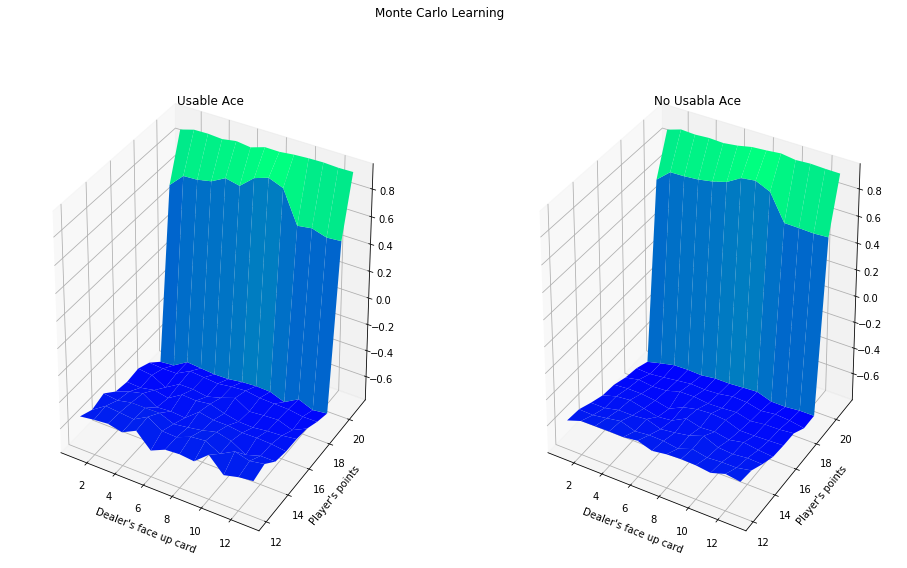

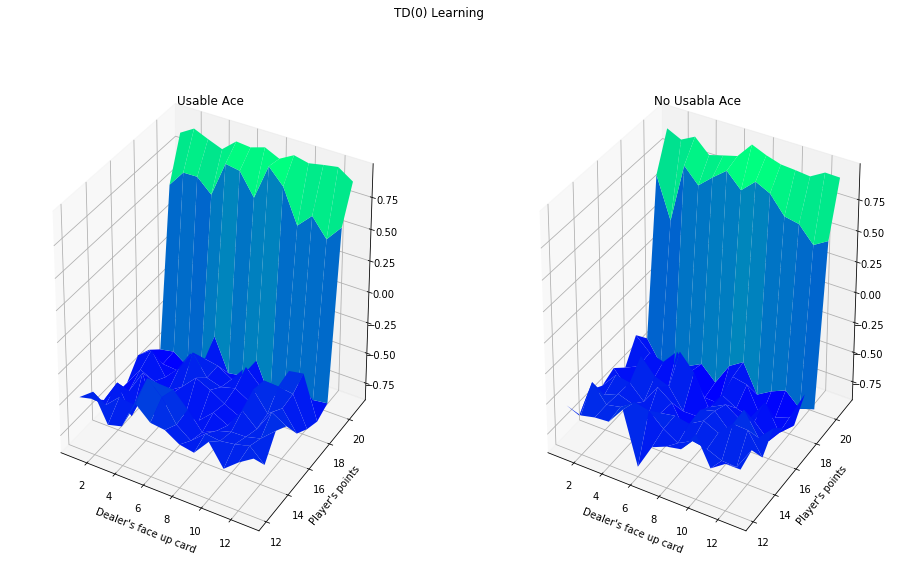

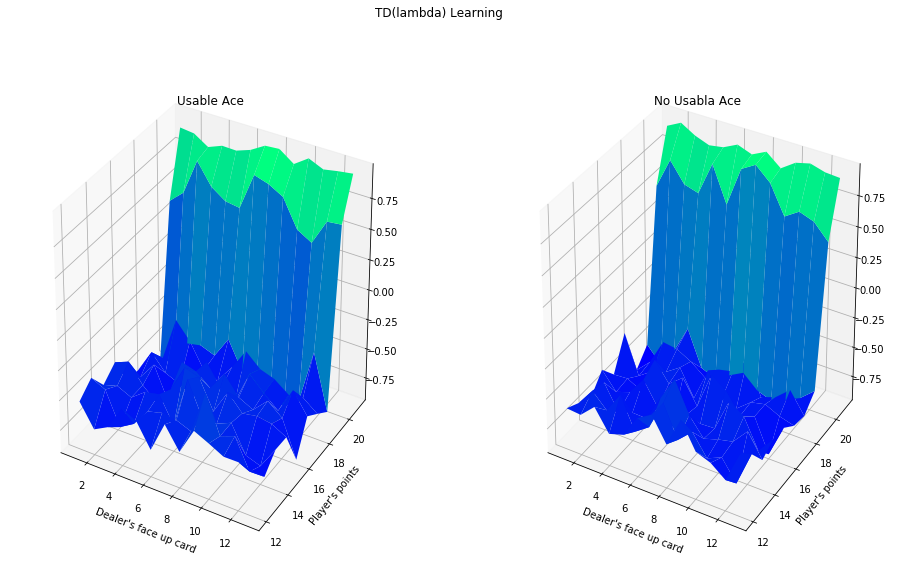

In [174]:
plot_result(V_mc, "Monte Carlo Learning")
plot_result(V_td0, "TD(0) Learning")
plot_result(V_tdlambda, "TD(lambda) Learning")